In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dacon/train.csv',index_col=0)
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dacon/test.csv',index_col=0)
submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dacon/submission.csv',index_col=0)

In [4]:
train.shape

(2048, 786)

In [5]:
train.head()

,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,2,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,1,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,4,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,2,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [6]:
test.shape

(20480, 785)

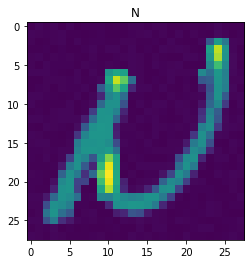

7


In [7]:
import random
rndidx = random.randint(0,2048)

img = np.array(train.iloc[rndidx,2:]).reshape(28,28).astype(np.float32)
plt.title(train.iloc[rndidx,1])
plt.imshow(img)
plt.show()
print(train.iloc[rndidx,0])

In [8]:
from keras.utils.np_utils import to_categorical
x_train = np.array(train.iloc[:,2:]).reshape(-1,28,28,1).astype(np.float32)
y_train = to_categorical(train['digit'].values)

x_train = x_train/255.

x_train.shape, y_train.shape

((2048, 28, 28, 1), (2048, 10))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1)

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [11]:
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

In [20]:
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout
from keras import backend as K

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper
        

def VGG16_BN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')

In [24]:
#위에거를 틀만가져오자.
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout
from keras import backend as K

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper

def VGG16_BN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # Block 5
    # x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=1)(x)
    # x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=2)(x)
    # x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=3)(x)
    # x = MaxPooling2D((2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')

In [25]:
model = VGG16_BN(input_shape=(28,28,1),classes = 10)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:






# from tensorflow.keras import activations
# model = keras.models.Sequential()

# model.add(keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1),padding='same'))
# model.add(keras.layers.Conv2D(32, kernel_size = 3,use_bias=False,padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation(activations.relu))

# model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu',padding='same'))
# model.add(keras.layers.Conv2D(64, kernel_size = 3,use_bias=False,padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation(activations.relu))
# model.add(keras.layers.MaxPooling2D((2,2)))


# model.add(keras.layers.Conv2D(128, kernel_size = 3, activation='relu',padding='same'))
# model.add(keras.layers.Conv2D(128, kernel_size = 3,use_bias=False,padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation(activations.relu))


# model.add(keras.layers.Conv2D(256, kernel_size = 3, activation='relu',padding='same'))
# model.add(keras.layers.Conv2D(256, kernel_size = 3,use_bias=False,padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation(activations.relu))
# model.add(keras.layers.MaxPooling2D((2,2)))

# model.add(keras.layers.Conv2D(256, kernel_size = 3, activation='relu',padding='same'))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(10, activation='softmax'))

# # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
# model.add(keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
# model.add(keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
# model.add(keras.layers.Dropout(0.4))

# model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
# model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
# model.add(keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
# model.add(keras.layers.Dropout(0.4))

# model.add(keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dropout(0.4))
# model.add(keras.layers.Dense(10, activation='softmax'))

# # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
annealer = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

model.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs = 50,
    steps_per_epoch = x_train.shape[0]//32,
    validation_data = (x_val, y_val),
    callbacks = [annealer],
    verbose=1
)


Epoch 1/50
57/57 [==============================] - 3s 46ms/step - loss: 2.5101 - accuracy: 0.1590 - val_loss: 2.3665 - val_accuracy: 0.0976
Epoch 2/50
57/57 [==============================] - 2s 29ms/step - loss: 2.2767 - accuracy: 0.2137 - val_loss: 2.7558 - val_accuracy: 0.0976
Epoch 3/50
57/57 [==============================] - 2s 29ms/step - loss: 2.1048 - accuracy: 0.2711 - val_loss: 3.2750 - val_accuracy: 0.0976
Epoch 4/50
57/57 [==============================] - 2s 30ms/step - loss: 1.8551 - accuracy: 0.3617 - val_loss: 4.2979 - val_accuracy: 0.0976
Epoch 5/50
57/57 [==============================] - 2s 29ms/step - loss: 1.6126 - accuracy: 0.4495 - val_loss: 5.7395 - val_accuracy: 0.0976
Epoch 6/50
57/57 [==============================] - 2s 30ms/step - loss: 1.5384 - accuracy: 0.4660 - val_loss: 6.0542 - val_accuracy: 0.0976
Epoch 7/50
57/57 [==============================] - 2s 29ms/step - loss: 1.3387 - accuracy: 0.5522 - val_loss: 5.7049 - val_accuracy: 0.0976
Epoch 8/50
57